# Optimal transport non-linearities and boundary conditions, in 1D

The PDE formulation of the optimal transport problem reads as follows:
$$
    f(x)-g(\nabla u(x))\det(\nabla^2 u(x)) = 0,
$$
subject to the constraint
$$
    u \quad \text{convex},
$$
and the boundary condition
$$
    \nabla u(X) = Y,
$$
where $X$ is the source domain, and $Y$ is the target domain. The parameters of the PDE are the densities $f$ and $g$, which are non-negative and subject to the compatibility condition
$$
    \int_X f(x) dx = \int_Y g(y) dy.
$$

This mathematical problem comes with a number of challenges, of both theoretical and numerical nature, including the:
1. Full non-linearity of the second order operator.
2. Constraint of convexity
3. Unspecified non-linearity of the first order operator.
4. Lack of a comparison principle.

Challenges 1. and 2. are related with the Monge-Ampere operator $\det(\nabla^2 u)$. They are discussed  the notebook 
[C.I Monge-Ampere equations](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/MongeAmpere.ipynb)

This notebook is devoted to challenges 3. and 4., in a simplified one dimensional setting.
In practice, 3. is mostly an implementation problem. Substantial theoretical work has been required to address 4. however. It is based on the observation that the second boundary condition could be weakened into 
$$
    \nabla u(X) \subset Y,
$$
and that equality must hold for the solution due to the compatibility condition relating the problem parameter densities.

**Note on one dimensional optimal transport.**
It is well known that one dimensional optimal transport (with a convex cost function) is nothing else than a sorting problem. As such it can be solved extremely efficiently, at a quasi-linear cost, and is considered a solved algorithmic problem.
The interest of numerical techniques presented in this notebook lies is their possible extension to higher dimensions.

**References**

* Benamou, J.-D., & Duval, V. (2017). Minimal convex extensions and finite difference discretisation of the quadratic Monge--Kantorovich problem. European Journal of Applied Mathematics, 1–38.

## The one-dimensional problem

In dimension one, the Monge-Ampere operator reduces to the usual laplacian operator, and the related difficulties 1. and 2. disappear. We are left with the equation
$$
    f(x) - g(u'(x)) u''(x) = 0,
$$
subject to the boundary conditions
$$
    u'(x_*) =  y_*, \quad u'(x^*) = y^*,
$$
where $X=[x_*,x^*]$ and $Y = [y_*,y^*]$ are the source and target intervals. Again the problem parameters are subject to the compatibility conditions
$$
    \int_{x_*}^{x^*} f(x) dx = \int_{y_*}^{y^*} g(y) dy,
$$
and this allows to weaken the boundary conditions into 
$$
    u'(x_*) \geq  y_*, \quad u'(x^*) \leq y^*.
$$

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import AutomaticDifferentiation as ad

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time

Some utility functions

In [3]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

In [4]:
def solve_Newton(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = guess+ad.Sparse.identity(guess.shape)
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0 or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue))
        u += (residue+relax).solve()
    return np.array(u)

In [5]:
def reload_packages():
    import importlib
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    fd = importlib.reload(sys.modules['NumericalSchemes.FiniteDifferences'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)

## 1. Second boundary conditions

We further simplify the problem and assume $g \equiv 1$, to study the weakened *second boundary conditions* that we rewrite as 
$$
    y_* - u'(x_*) \leq 0, \quad u'(x^*) - y^*\leq 0,
$$
at the endponts of the interval $[x_*,x^*]$ of definition of the problem solution $u$.
Recall that the PDE solved is 
$$
    f(x) - u''(x) = 0,
$$
and that we have 
$$
    \int_{x_*}^{x^*} f(x) dx = y^*-y_*.
$$

**Explicit solution.**
The above problem admits a one dimensional, family of explicit solutions. Namely
$$
u(x) = \alpha + r x + v(x),
$$
where $v$ is a second primitive of $u$, and the constant $r$ is adequately chosen to match the boundary conditions.
The other constant, named $\alpha$, is *arbitrary*.

### Montone discretization

We may define a monotone (degenerate elliptic) discretization of the boundary conditions, using upwind finite differences as follows
$$
    \max\{0,y_* - \frac{u(x_*+h)-u(x_*)} h\} = 0, \quad \max\{0,\frac{u(x^*)-u(x^*-h)} h - y^*\}= 0.
$$
We also use the standard discretization of the laplacian operator in the interior.

The resulting discretization obeys the assumptions of a degenerate elliptic (monotone) scheme, since it takes the form
$$
    F u(x) := F(x,u(x),(u(x)-u(x'))_{x' \in X} ),
$$
where $F$ is a non-decreasing function of its second and third arguments.

### Non-uniqueness and lack of a comparision principle

The continuous problems admits, as mentioned above, a one dimensional family of solutions. The discrete problem, on the other hand, admits either no solution, or a large and typically multi-dimensional family of solutions.

These indeterminacies reflect a failure of the comparison principle, due to the impossibility to perturb a given solution into a strict sub-solution.

In [9]:
def Scheme(u,f,bc,h):
    residue = f-fd.Diff2(u,(1,),h)
    bc = ad.toarray(bc,type(u)) # Needed due to problem with autodiff array scalars
    residue[0]  = np.maximum(0.,bc[0] - (u[1]-u[0])/h)
    residue[-1] = np.maximum(0.,(u[-1]-u[-2])/h - bc[1])
    return residue

In [7]:
X = np.linspace(-1,1,101,endpoint=True)
gridScale = X[1]-X[0]
f = 1.+0.9*np.sin(2.*np.pi*X)
bc = np.array((-1.,1.))

guess = np.zeros(X.shape)

The discretized problem is linear. However, the jacobian matrix $J$ is rank deficient and non-invertible.
Fortunately, thanks to the scheme monotony, the matrix 
$$
    J+\epsilon {\rm Id} 
$$
is invertible for every $\epsilon>0$.
We use an iterative method, featuring such a relaxation, so solve the problem.

In order to illustrate the dichotomy between *no solution* and *infinitely may solutions, we perturb a bit the boundary conditions.

**Note on convergence (No solution).**
The discretized problem addressed here has *no solution*. As a result, the Newton solver residues do not tend to zero (or numerical precision). This is expected behavior.

In [10]:
bc2 = np.array((-1,1-2*gridScale))
params = (f,bc2,gridScale)
relax = ad.Sparse.identity(X.shape)*gridScale
solution = solve_Newton(Scheme,params,guess,relax=relax)

Iteration : 0 , Residue norm : 1.8982240555854444
Iteration : 1 , Residue norm : 0.12636527953248167
Iteration : 2 , Residue norm : 0.009998009013359899
Iteration : 3 , Residue norm : 0.005066525567447577
Iteration : 4 , Residue norm : 0.005025995705958408
Iteration : 5 , Residue norm : 0.00502514748832894
Iteration : 6 , Residue norm : 0.005025126195161711
Iteration : 7 , Residue norm : 0.005025125643211226


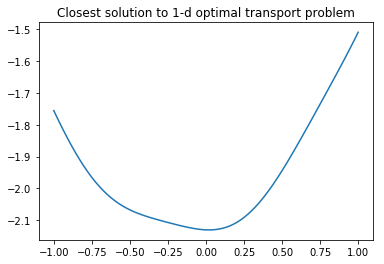

In [11]:
plt.title("Closest solution to 1-d optimal transport problem")
plt.plot(X,solution);

We next perturb a bit the boundary conditions, ensuring, this time, that the discretized problem has *an infinity of solutions*.

**Note on convergence (degenerate solutions).**
The discretized problem addressed here has a two dimensional non-linear family of solutions. It is also non-differentiable. As a result, the Newton solve takes more steps to reach numerical precision than what could be expected for problems this size.

In [13]:
bc3 = np.array((-1,1+2*gridScale))
params = (f,bc3,gridScale)
relax = ad.Sparse.identity(X.shape) * gridScale
solution = solve_Newton(Scheme,params,guess,relax=relax,niter=12)

Iteration : 0 , Residue norm : 1.8982240555854444
Iteration : 1 , Residue norm : 0.12636527953248167
Iteration : 2 , Residue norm : 0.0049899647157736204
Iteration : 3 , Residue norm : 0.0003108032158998242
Iteration : 4 , Residue norm : 1.9903133235965598e-05
Iteration : 5 , Residue norm : 1.2774458824083013e-06
Iteration : 6 , Residue norm : 8.200718704109988e-08
Iteration : 7 , Residue norm : 5.264649827196877e-09
Iteration : 8 , Residue norm : 3.3797675769164925e-10
Iteration : 9 , Residue norm : 2.169642243643466e-11
Iteration : 10 , Residue norm : 1.7261747586871934e-12
Iteration : 11 , Residue norm : 6.539213615042172e-13


## 2. Non-linearity in the gradient 

We solve the PDE 
$$
f(x)/g(u'(x)) - u''(x)=0
$$

In [14]:
def SchemeGradient(u,f,g,bc,h):
    residue = f/g(fd.DiffCentered(u,(1,),h))-fd.Diff2(u,(1,),h)
    bc = ad.toarray(bc,type(u)) # Needed due to problem with autodiff array scalars
    residue[0]  = np.maximum(0.,bc[0] - (u[1]-u[0])/h)
    residue[-1] = np.maximum(0.,(u[-1]-u[-2])/h - bc[1])
    return residue

In [15]:
X = np.linspace(-1,1,101,endpoint=True)
gridScale = X[1]-X[0]
f = 1.+0.9*np.sin(2.*np.pi*X)
bc = np.array((-1.,1.))

g = 1.+0.5*np.cos(2.*np.pi*X)
f*=g.sum()/f.sum()
g_interp=fd.UniformGridInterpolator1D(X,g)

guess = np.zeros(X.shape)

In [16]:
params = (f,g_interp,bc,gridScale)
relax = ad.Sparse.identity(X.shape) * gridScale
solution = solve_Newton(SchemeGradient,params,X,relax=relax,niter=15)

Iteration : 0 , Residue norm : 1.2717474695837614
Iteration : 1 , Residue norm : 2.276164965291264
Iteration : 2 , Residue norm : 6.9793294237230175
Iteration : 3 , Residue norm : 8.62442150407455
Iteration : 4 , Residue norm : 9.030547460925924
Iteration : 5 , Residue norm : 2.1593586930652617
Iteration : 6 , Residue norm : 9.625961543891806
Iteration : 7 , Residue norm : 0.43721888690293165
Iteration : 8 , Residue norm : 0.011620928557829924
Iteration : 9 , Residue norm : 0.03270058671252496
Iteration : 10 , Residue norm : 0.0031334056757930107
Iteration : 11 , Residue norm : 1.0784461546009538e-06
Iteration : 12 , Residue norm : 7.999409468162355e-08
Iteration : 13 , Residue norm : 5.972761174533048e-09
Iteration : 14 , Residue norm : 4.4594883341630975e-10


Check the solution.

In [19]:
def g_exact(X): return  1.+0.5*np.cos(2.*np.pi*X)
g_exact(fd.DiffCentered(solution,(1,),gridScale))*fd.Diff2(solution,(1,),gridScale) - f

array([ 2.38424043e+03,  6.87752070e-04,  4.25206455e-04,  6.73276032e-05,
        1.32371044e-04,  4.45241262e-05,  3.27475346e-04,  7.37172119e-04,
        7.38009915e-04,  1.51162511e-04,  3.57745136e-04,  4.42616248e-06,
       -5.29399662e-04, -6.49201475e-04, -2.02727197e-03, -8.13390678e-04,
       -3.11913560e-03, -6.59391794e-04, -1.30583300e-03, -4.67603118e-04,
       -1.92582254e-04,  4.54393428e-05,  2.70862707e-04,  3.77276470e-04,
        4.26261455e-04,  3.84354439e-04,  6.74034726e-05,  3.50023114e-04,
        2.35559175e-04,  2.84914959e-04,  2.42831795e-05,  1.98979131e-04,
        1.76887342e-04,  1.02029415e-04,  3.46066546e-05,  9.94267586e-06,
        3.01382668e-05,  3.95303672e-05,  4.91277550e-05,  6.44711861e-05,
        8.73775183e-05,  1.13780009e-04,  1.26281770e-04,  7.92729470e-05,
        1.02323068e-04,  2.91503638e-04,  2.61708869e-04,  2.59982377e-04,
        4.49194726e-04,  4.13066822e-04,  3.15632509e-04,  7.20793242e-04,
        7.32814821e-04,  